## Re-run Modeling spawning salmon with PyMC v4
Source: https://github.com/fonnesbeck/gp_regression/blob/master/notebooks/spawning_salmon.ipynb

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pymc as pm
import aesara as ae
import arviz as az
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter('ignore')

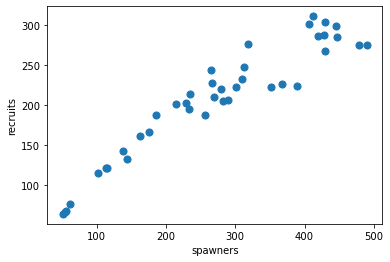

In [2]:
salmon_data = pd.read_table('../data/salmon.txt', sep='\s+', index_col=0)
salmon_data.plot.scatter(x='spawners', y='recruits', s=50);

In [3]:
x, y = salmon_data[['spawners', 'recruits']].values.T

### Gaussian Process

In [4]:
with pm.Model() as gp_salmon_model:

    # Lengthscale
    ρ = pm.HalfCauchy('ρ', 5)
    η = pm.HalfCauchy('η', 5)
    
    M = pm.gp.mean.Linear(coeffs=(salmon_data.recruits/salmon_data.spawners).mean())
    K = (η**2) * pm.gp.cov.ExpQuad(1, ρ) 
    
    σ = pm.HalfNormal('σ', 50)
    
    recruit_gp = pm.gp.Marginal(mean_func=M, cov_func=K)
    recruit_gp.marginal_likelihood('recruits', X=salmon_data.spawners.values.reshape(-1,1), 
                           y=salmon_data.recruits.values, noise=σ)   

#### Using trace

In [5]:
with gp_salmon_model:
    gp_trace = pm.sample(1000, tune=2000, cores=2, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ρ, η, σ]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 19 seconds.


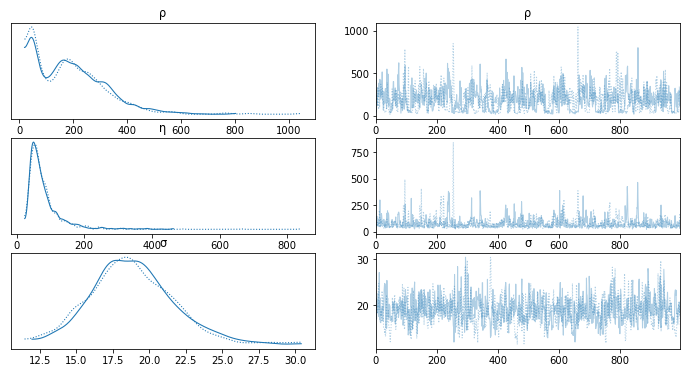

In [6]:
az.plot_trace(gp_trace, var_names=['ρ', 'η', 'σ']);

In [7]:
X_pred = np.linspace(0, 500, 100)
with gp_salmon_model:
    salmon_pred = recruit_gp.conditional("salmon_pred", X_pred.reshape(-1, 1))
    gp_salmon_samples = pm.sample_posterior_predictive(gp_trace, var_names=['salmon_pred'], 
                                                       random_seed=42)

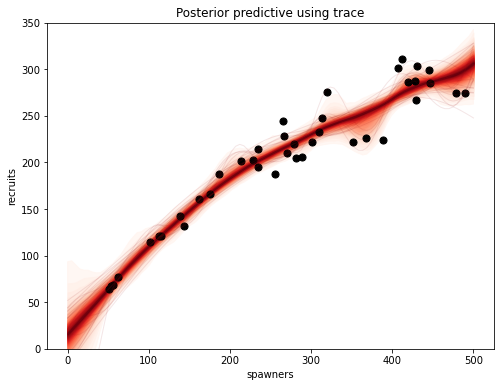

In [8]:
# Plot posterior predictive with X_pred using trace
from pymc.gp.util import plot_gp_dist
fig, ax = plt.subplots(figsize=(8,6))
plot_gp_dist(ax, gp_salmon_samples.posterior_predictive['salmon_pred'].sel(chain=1), X_pred)
salmon_data.plot.scatter(x='spawners', y='recruits', c='k', s=50, ax=ax)
ax.set_ylim(0, 350);
plt.title("Posterior predictive using trace");

#### Using find MAP

In [9]:
with gp_salmon_model:
    mp = pm.find_MAP()
    salmon_pred_map = recruit_gp.conditional("salmon_pred_map", X_pred.reshape(-1, 1))
    salmon_samples = pm.sample_posterior_predictive([mp], samples=1000, 
                                                    var_names=['salmon_pred_map'], keep_size=False)

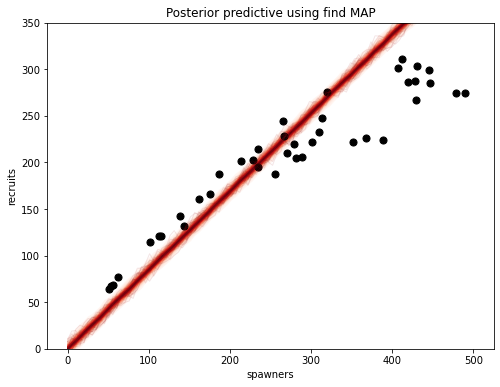

In [10]:
# THIS SEEMS WRONG!!!
from pymc.gp.util import plot_gp_dist
fig, ax = plt.subplots(figsize=(8,6))
plot_gp_dist(ax, salmon_samples.posterior_predictive['salmon_pred_map'].sel(chain=0), X_pred)
salmon_data.plot.scatter(x='spawners', y='recruits', c='k', s=50, ax=ax)
ax.set_ylim(0, 350)
plt.title("Posterior predictive using find MAP");

In [11]:
mp_log = {k: v for k, v in mp.item}

{'ρ_log__': array(1.60943791),
 'η_log__': array(1.60943791),
 'σ_log__': array(3.91202301),
 'salmon_pred': array([5.23321029e-24, 4.26462020e+00, 8.52924040e+00, 1.27938606e+01,
        1.70584808e+01, 2.13231014e+01, 2.55877632e+01, 2.98541057e+01,
        3.41452975e+01, 3.85628976e+01, 4.31390661e+01, 4.75491260e+01,
        5.16589097e+01, 5.56731219e+01, 5.97614014e+01, 6.39749024e+01,
        6.82341651e+01, 7.25001045e+01, 7.67875729e+01, 8.11663545e+01,
        8.55912470e+01, 8.99055048e+01, 9.42826203e+01, 9.85248547e+01,
        1.02525325e+02, 1.06657671e+02, 1.10988576e+02, 1.15415093e+02,
        1.19697871e+02, 1.23826140e+02, 1.28004626e+02, 1.32340659e+02,
        1.36709740e+02, 1.40917741e+02, 1.45157486e+02, 1.49490101e+02,
        1.53829440e+02, 1.58108664e+02, 1.62208568e+02, 1.66348409e+02,
        1.70598006e+02, 1.74926406e+02, 1.79301645e+02, 1.83548962e+02,
        1.87737250e+02, 1.92038567e+02, 1.96355982e+02, 2.00575683e+02,
        2.04741778e+02, 2.08

In [22]:
mp_log = {k: v for k, v in mp.items() if "log" in k or "pred" in k}
mp_log

{'ρ_log__': array(1.60943791),
 'η_log__': array(1.60943791),
 'σ_log__': array(3.91202301),
 'salmon_pred': array([5.23321029e-24, 4.26462020e+00, 8.52924040e+00, 1.27938606e+01,
        1.70584808e+01, 2.13231014e+01, 2.55877632e+01, 2.98541057e+01,
        3.41452975e+01, 3.85628976e+01, 4.31390661e+01, 4.75491260e+01,
        5.16589097e+01, 5.56731219e+01, 5.97614014e+01, 6.39749024e+01,
        6.82341651e+01, 7.25001045e+01, 7.67875729e+01, 8.11663545e+01,
        8.55912470e+01, 8.99055048e+01, 9.42826203e+01, 9.85248547e+01,
        1.02525325e+02, 1.06657671e+02, 1.10988576e+02, 1.15415093e+02,
        1.19697871e+02, 1.23826140e+02, 1.28004626e+02, 1.32340659e+02,
        1.36709740e+02, 1.40917741e+02, 1.45157486e+02, 1.49490101e+02,
        1.53829440e+02, 1.58108664e+02, 1.62208568e+02, 1.66348409e+02,
        1.70598006e+02, 1.74926406e+02, 1.79301645e+02, 1.83548962e+02,
        1.87737250e+02, 1.92038567e+02, 1.96355982e+02, 2.00575683e+02,
        2.04741778e+02, 2.08

In [16]:
print(gp_salmon_model.compile_logp(jacobian=False))

In [23]:
gp_salmon_model.compile_logp(jacobian=False)(mp_log)

TypeError: Missing required input: salmon_pred_map

In [12]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sat Jun 04 2022

Python implementation: CPython
Python version       : 3.9.12
IPython version      : 8.3.0

numpy     : 1.22.4
pymc      : 4.0.0b6
aesara    : 2.6.2
matplotlib: 3.5.2
pandas    : 1.4.2
arviz     : 0.12.1

Watermark: 2.3.0

